In [1]:
import sys
sys.path.append('/f/Downloads/mroc-master/')

import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier, plot_importance
from tqdm import tqdm
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from collections import defaultdict
import pandas as pd
import os
import joblib
import mroc
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score, accuracy_score
import lightgbm as lgb
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    #tensorflow.set_random_seed(seed)

In [10]:
folder = '../data/collabTrain_work/train'
features = [
     # 'ObjectSpec',
#     'SimilarOwners',
#     'OwnerReact',
#     'SvdCols',
#     'ResourceType',
#     'AuditweightsMatrix',
#     'AuditweightsCtrHigh',
#     'AuditweightsNumLikes',
#     'MetadataNumSymbols',
#     'UserOwnerCounter',
    'AuthorReact2'
    ]
X = []
Y = joblib.load(os.path.join(folder, 'Target')).toarray().squeeze()
uo = joblib.load(os.path.join(folder, 'UserIdObjectId')).toarray()
user_ids, obj_ids = uo[:,0], uo[:,1]

feature_names = []
print('Loading features')
for f in tqdm(features):
    x = joblib.load(os.path.join(folder, f))
    if len(x.shape)==1:
        x = x.toarray().unsqueeze(0)
    assert x.shape[0]==Y.shape[0], f'{f} has {len(x)}, Y has {len(Y)}'
    X.append(x)
    feature_names.extend([f]*x.shape[1])
print('Stacking features')
X = sparse.hstack(X)
print('Dividing on train/valid parts')

valid_count = int(X.shape[0]*0.1)
X_train, X_valid = X[:valid_count], X[-valid_count:]
Y_train, Y_valid = Y[:valid_count], Y[-valid_count:]
user_id_train, user_id_valid = user_ids[:valid_count], user_ids[-valid_count:]

print('Done')

  0%|          | 0/1 [00:00<?, ?it/s]

Loading features


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Stacking features
Dividing on train/valid parts
Done


In [11]:
seed_everything(6)
model = LGBMClassifier()
model.fit(X_train, Y_train, verbose=True, eval_set=(X_valid, Y_valid), eval_metric='auc',
          early_stopping_rounds=5, feature_name = feature_names)

mroc.mean_roc_auc(user_id_valid, Y_valid, model.predict_proba(X_valid)[:,1])

[1]	valid_0's auc: 0.65402
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.658769
[3]	valid_0's auc: 0.660967
[4]	valid_0's auc: 0.662791
[5]	valid_0's auc: 0.664186
[6]	valid_0's auc: 0.665831
[7]	valid_0's auc: 0.666293
[8]	valid_0's auc: 0.666993
[9]	valid_0's auc: 0.668002
[10]	valid_0's auc: 0.668554
[11]	valid_0's auc: 0.668983
[12]	valid_0's auc: 0.669442
[13]	valid_0's auc: 0.669341
[14]	valid_0's auc: 0.669992
[15]	valid_0's auc: 0.671603
[16]	valid_0's auc: 0.671821
[17]	valid_0's auc: 0.673053
[18]	valid_0's auc: 0.674283
[19]	valid_0's auc: 0.675049
[20]	valid_0's auc: 0.675577
[21]	valid_0's auc: 0.676409
[22]	valid_0's auc: 0.678951
[23]	valid_0's auc: 0.679918
[24]	valid_0's auc: 0.680531
[25]	valid_0's auc: 0.6808
[26]	valid_0's auc: 0.681969
[27]	valid_0's auc: 0.682426
[28]	valid_0's auc: 0.683245
[29]	valid_0's auc: 0.683578
[30]	valid_0's auc: 0.683805
[31]	valid_0's auc: 0.684503
[32]	valid_0's auc: 0.685566
[33]	valid_0's auc: 0.6

0.7053165934545744

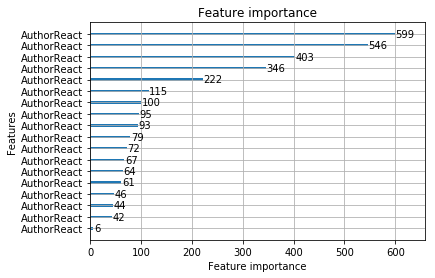

In [5]:
plot_importance(model)

## Valid

## Infer

In [8]:
! ls ../data/collabTrain_work/test

Audit		     ObjectSpec    SimilarOwners
AuditweightsCtrHigh  OwnerReact    SvdCols
AuditweightsMatrix   ResourceType  UserIdObjectId


In [10]:
X[0].shape

(1181443, 2)

In [15]:
obj_ids.shape

(1181443,)

In [20]:
user_ids[:10], obj_ids[:10]

(array([5129604., 5129604., 5129604., 5129604., 5129604., 5129604.,
        5129604., 5129604., 5129604., 5129604.]),
 array([31268404., 37281624., 32979002., 38236802., 20034016., 30812434.,
        24193834., 20152524., 26281832., 34393219.]))

In [26]:
user_ids[:10], obj_ids[:10]

(array([7138812., 7138812., 7138812., 7139190., 7139190., 7139190.,
        7139403., 7139403., 7140543., 7140543.]),
 array([16981818., 10654239.,  9474919., 38634914., 37947924., 33492019.,
        24078331., 36232204., 23865017.,   606918.]))

In [9]:
user_ids[:10], obj_ids[:10]

(array([7138812., 7138812., 7138812., 7139190., 7139190., 7139190.,
        7139403., 7139403., 7140543., 7140543.]),
 array([16981818., 10654239.,  9474919., 38634914., 37947924., 33492019.,
        24078331., 36232204., 23865017.,   606918.]))

In [7]:
folder = '../data/collabTrain_work/test'
out_file = '../data/collabTrain_work/submissions/submit.csv.gz'
os.makedirs(os.path.dirname(out_file), exist_ok=True)
X = []
uo = joblib.load(os.path.join(folder, 'UserIdObjectId')).toarray()
user_ids, obj_ids = uo[:,0], uo[:,1]

print('Loading features')
for f in tqdm(features):
    X.append(joblib.load(os.path.join(folder, f)))
print('Stacking features')
X = sparse.hstack(X)
assert len(user_ids)==X.shape[0]

pred = model.predict_proba(X)[:,1]

by_user = defaultdict(list)
for user_id, obj_id, p in zip(user_ids, obj_ids, pred):
    by_user[int(user_id)].append([int(obj_id), p])

data = []
index = []
for k, v in by_user.items():
    index.append(k)
    data.append([item[0] for item in sorted(v, reverse=True, key=lambda x: x[1])])

by_user = pd.DataFrame(data={'0': data}, index=index).sort_index()
print(by_user.head())
by_user.to_csv(out_file, header=False, compression='gzip')

  0%|          | 0/11 [00:00<?, ?it/s]

Loading features


100%|██████████| 11/11 [00:00<00:00, 15.41it/s]


Stacking features


/opt/anaconda/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


                                                     0
39            [35321415, 18936317, 38436621, 38345738]
78                        [38727626, 549335, 14594128]
135  [17738426, 17551814, 38102135, 27720022, 35113...
180                               [35804715, 12537921]
231             [30371401, 975302, 30978017, 34978207]


In [8]:
pred

array([0.13406835, 0.18125334, 0.11955963, ..., 0.40099543, 0.02154874,
       0.43700664])